# Foam fingering paper computations
This is the final notebook for the regeneration of the simulation results for our SPE RSS paper, which is now submitted to the journal of natural gas (or sth like that). I have not included the gravity effect in the code, so only the results from cases 1 to 4 can be regenerated here.

## Load the foam functions and run

In [2]:
using JFVM, Roots, PyPlot, ProgressMeter, DataFrames, Dierckx, JLD

In [3]:
include("frac_flow_funcs.jl")

foam_stars (generic function with 1 method)

## Read our paper foam model data
I've modified two cases to match them with the description in the paper. Perhaps Rouhi can explain it.

In [4]:
data1=readtable("TableA1.csv")

,parameter,fmmob,fmdry,epdry,krw0,krg0,swc,sgc,nw,ng,muw,mug,rhow,rhog
1,case1,8000,0.268,100000,0.2,0.94,0.1,0.05,2.0,1.8,0.00065,5.0e-5,985,100
2,case2,13000,0.268,100000,0.2,0.94,0.1,0.05,2.0,1.8,0.00065,5.0e-5,985,100
3,case3,25000,0.29,10000,0.2,0.94,0.1,0.05,4.2,1.3,0.001,2.0e-5,985,100
4,case4,25000,0.29,100,0.2,0.94,0.1,0.05,4.2,1.3,0.001,2.0e-5,985,100


### Original data that I have modified:

In [26]:
readtable("TableA1_orig.csv")

,parameter,fmmob,fmdry,epdry,krw0,krg0,swc,sgc,nw,ng,muw,mug,rhow,rhog
1,case1,18000.0,0.268,100000.0,0.2,0.94,0.1,0.05,2.0,1.8,0.00065,5.0e-5,985,100
2,case2,25000.0,0.29,100000.0,0.2,0.94,0.1,0.05,4.2,1.3,0.001,2.0e-5,985,100
3,case3,25000.0,0.29,10000.0,0.2,0.94,0.1,0.05,4.2,1.3,0.001,2.0e-5,985,100
4,case4,25000.0,0.29,100.0,0.2,0.94,0.1,0.05,4.2,1.3,0.001,2.0e-5,985,100



## How to use this notebook
Change the `case_no` variable to between 1 to 4 and run the notebook to obtain the results of the paper.

In [5]:
case_no=2
fmmob=data1[:fmmob][case_no]
epdry=data1[:epdry][case_no]
fmdry=data1[:fmdry][case_no]
krw0=data1[:krw0][case_no]
krg0=data1[:krg0][case_no]
swc=data1[:swc][case_no]
sgc=data1[:sgc][case_no]
nw=data1[:nw][case_no]
ng=data1[:ng][case_no]
muw=data1[:muw][case_no]
mug=data1[:mug][case_no]

5.0e-5

In [6]:
# load Corey-type and foam relperms
(krw, krg, dkrwdsw, dkrgdsw, krgf, dkrgfdsw)=corey_rel_perms(
    swc=swc, sgr=sgc, krg0=krg0, ng=ng, krw0=krw0,
    nw=nw, fmmob=fmmob, epdry=epdry, fmdry=fmdry)
# Define the fractional flow functions
fw(sw)=(krg(sw)/mug)./(krg(sw)/mug+krw(sw)/muw)
fw_foam(sw)=(krgf(sw)/mug)./(krgf(sw)/mug+krw(sw)/muw)
# define the mobility function
labda_tot(sw)=krg(sw)/mug+krw(sw)/muw
labda_tot_foam(sw)=krgf(sw)/mug+krw(sw)/muw

labda_tot_foam (generic function with 1 method)

In [7]:
(xt_shock, sw_shock, xt_prf, sw_prf, t, p_inj)=frac_flow_wag(muw=muw, 
  mug=mug, ut=1e-5, phi=0.2,
k=1e-12, swc=swc, sgr=sgc, krg0=krg0, ng=ng, krw0=krw0,
  nw=nw, sw0=1.0, sw_inj=0.0, L=1, pv_inj=5)

(0.00020944152293314092,0.8395715957203321,[0.0,2.15964e-9,6.01464e-9,9.91109e-9,1.38495e-8,1.78302e-8,2.18538e-8,2.59207e-8,3.00314e-8,3.41864e-8  …  0.00017715,0.000181456,0.000185864,0.000190374,0.000194986,0.000199701,0.00020452,0.000209442,0.000209442,0.000418883],[0.0,0.10095,0.102633,0.104316,0.105998,0.107681,0.109363,0.111046,0.112728,0.114411  …  0.827794,0.829477,0.831159,0.832842,0.834524,0.836207,0.837889,0.839572,1.0,1.0],[2.22045e-16,1010.1,2020.2,3030.3,4040.4,5050.51,6060.61,7070.71,8080.81,9090.91  …  90909.1,91919.2,92929.3,93939.4,94949.5,95959.6,96969.7,97979.8,98989.9,100000.0],[6500.0,6931.75,7359.79,7795.41,8223.42,8231.0,7330.18,6659.67,6136.78,5715.08  …  1662.16,1653.68,1645.35,1637.17,1629.13,1621.23,1613.46,1605.82,1598.32,1590.93])

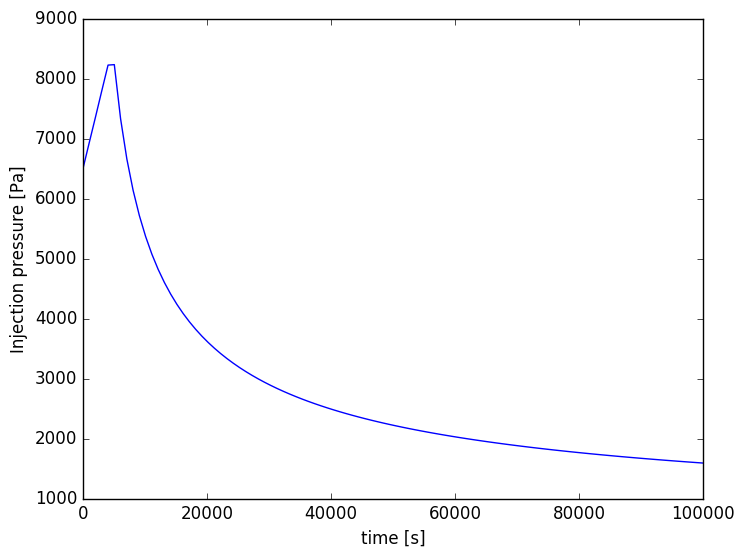

PyObject <matplotlib.text.Text object at 0x0000000021F05B38>

In [9]:
plot(t, p_inj)
xlabel("time [s]")
ylabel("Injection pressure [Pa]")

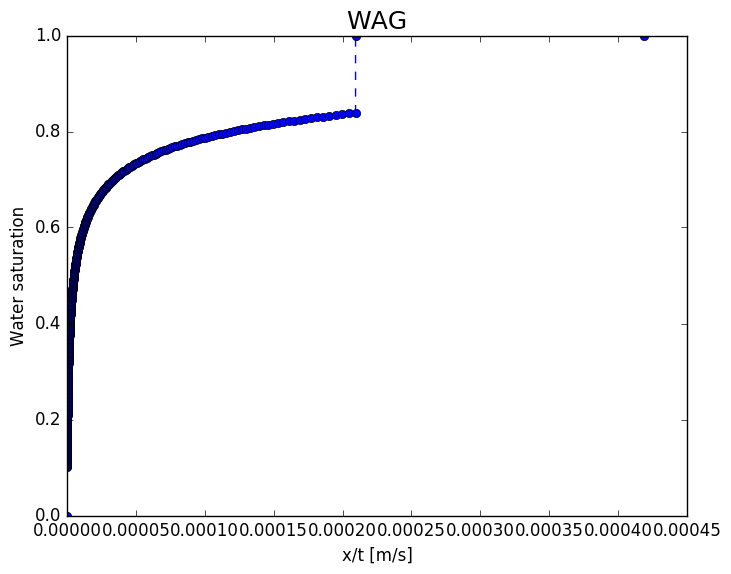

PyObject <matplotlib.text.Text object at 0x0000000022162D68>

In [10]:
plot(xt_prf, sw_prf, "o--")
ylabel("Water saturation")
xlabel("x/t [m/s]")
title("WAG", fontsize=18)

## Analytical solution for SAG

In [11]:
(xt_shock, sw_shock, xt_prf, sw_prf, t, p_inj)=frac_flow_sag(
fmmob=fmmob, epdry=epdry, fmdry=fmdry,
muw=muw, mug=mug, ut=1e-5, phi=0.2,
k=1e-12, swc=swc, sgr=sgc, krg0=krg0, ng=ng, krw0=krw0,
  nw=nw, sw0=1.0, sw_inj=0.0, L=1, pv_inj=5)

(6.729414396082649e-5,0.2626150511246399,[0.0,1.47184e-9,2.96923e-9,4.47448e-9,5.98765e-9,7.50881e-9,9.03803e-9,1.05754e-8,1.21209e-8,1.36747e-8  …  2.4178e-5,2.71749e-5,3.07775e-5,3.5161e-5,4.05688e-5,4.7347e-5,5.60013e-5,6.72941e-5,6.72941e-5,0.000134588],[0.0,0.10052,0.101046,0.101573,0.102099,0.102625,0.103151,0.103678,0.104204,0.10473  …  0.258931,0.259457,0.259984,0.26051,0.261036,0.261562,0.262089,0.262615,1.0,1.0],[2.22045e-16,1010.1,2020.2,3030.3,4040.4,5050.51,6060.61,7070.71,8080.81,9090.91  …  90909.1,91919.2,92929.3,93939.4,94949.5,95959.6,96969.7,97979.8,98989.9,100000.0],[6500.0,6375.54,6251.32,6127.08,6002.84,5878.6,5754.35,5630.11,5505.86,5381.61  …  2213.23,2203.78,2194.47,2185.31,2176.3,2167.43,2158.7,2150.1,2141.63,2133.28])

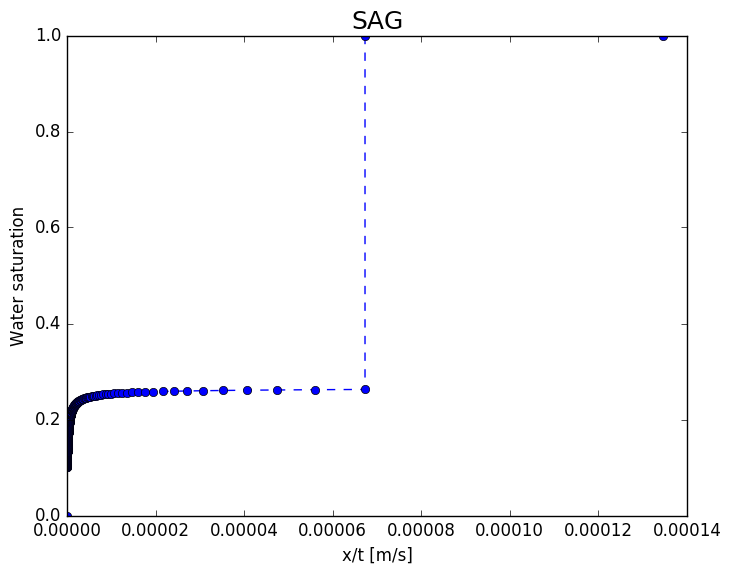

PyObject <matplotlib.text.Text object at 0x00000000261ABB00>

In [12]:
plot(xt_prf, sw_prf, "o--")
ylabel("Water saturation")
xlabel("x/t [m/s]")
title("SAG", fontsize=18)

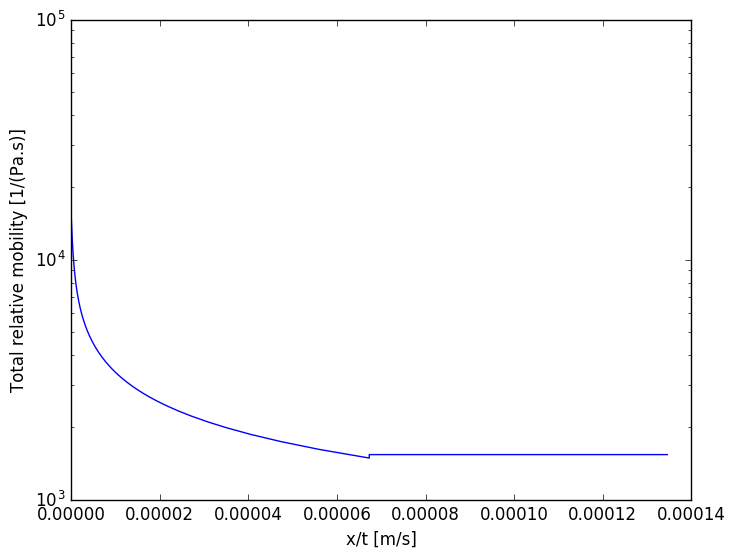

PyObject <matplotlib.text.Text object at 0x000000003B6FABE0>

In [31]:
semilogy(xt_prf, labda_tot_foam(sw_prf), "-")
xlabel("x/t [m/s]")
ylabel("Total relative mobility [1/(Pa.s)]")

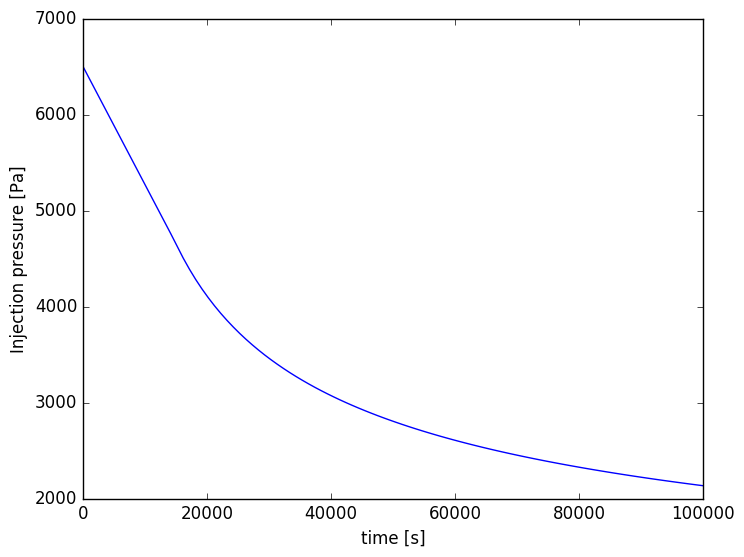

PyObject <matplotlib.text.Text object at 0x0000000026456588>

In [14]:
plot(t, p_inj)
xlabel("time [s]")
ylabel("Injection pressure [Pa]")

## Numerical models

In [15]:
include("foam_flow_two_phase.jl")

foam_stars (generic function with 1 method)

## 2D model inputs and results
### Initial saturation = shock saturation

In [16]:
Nx = 80 # number of cells in x direction
Ny = 80 # number of cells in y direction
W = 1 # width
H = 1 # height
x=[linspace(0,0.5,70); linspace(0.51, 1.0, 10)]
y=collect(linspace(0,H,Ny))
m = createMesh1D(x)
m2=createMesh2D(Nx,Ny, W, H);
perm_ave=1e-12
perm_field=permfieldlogrnde(Nx, Ny, perm_ave, 0.1, 0.1, 0.1);

In [20]:
sw2=foam_stars(m2, perm_ave=perm_field, poros_ave=0.2, sw_init=sw_shock, 
fmmob=fmmob, epdry=epdry, fmdry=fmdry,
muw=muw, mug=mug, swc=swc, sgr=sgc, krg0=krg0, ng=ng, krw0=krw0, nw=nw,
t_final=100, dt0=100.0/100);

Time loop:100%|██████████████████████████████████████████████████| Time: 0:00:26
Time loop:100%|██████████████████████████████████████████████████| Time: 0:00:27
Time loop:100%|██████████████████████████████████████████████████| Time: 0:00:27


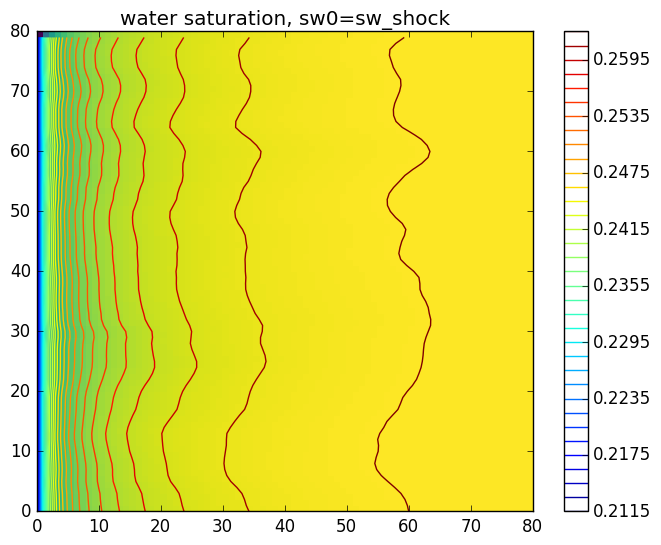

PyObject <matplotlib.text.Text object at 0x000000004E247978>

In [51]:
#save("case2_shocksat_2d.jld", "sw", sw2)
#visualizeCells(sw2)
pcolor(sw2.value[2:end-1,2:end-1]', cmap="viridis")
contour(sw2.value[2:end-1,2:end-1]', 40)
colorbar()
title("water saturation, sw0=sw_shock")

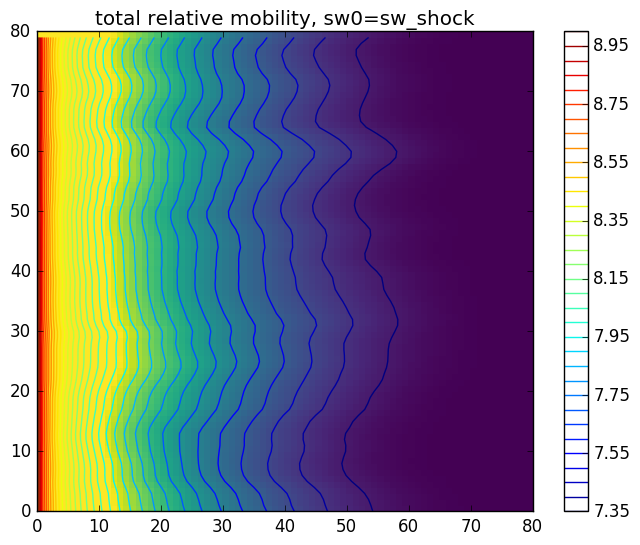

PyObject <matplotlib.text.Text object at 0x000000004D2A9B00>

In [50]:
#save("case1_shocksat_2d.jld", "sw", sw2)
pcolor(log(labda_tot_foam(sw2.value[2:end-1,2:end-1]')), cmap="viridis", vmax=8.0)
contour(log(labda_tot_foam(sw2.value[2:end-1,2:end-1]')), 40)
colorbar()
title("total relative mobility, sw0=sw_shock")

### Initial saturation = fully liquid saturated

In [23]:
sw2_sat=foam_stars(m2, perm_ave=perm_field, poros_ave=0.2, sw_init=1.0, 
fmmob=fmmob, epdry=epdry, fmdry=fmdry,
muw=muw, mug=mug, swc=swc, sgr=sgc, krg0=krg0, ng=ng, krw0=krw0, nw=nw,
t_final=100, dt0=100.0/500);

Time loop:100%|██████████████████████████████████████████████████| Time: 13:18:10
Time loop:100%|██████████████████████████████████████████████████| Time: 13:18:11
Time loop:100%|██████████████████████████████████████████████████| Time: 13:18:13
Time loop:100%|██████████████████████████████████████████████████| Time: 13:18:14
Time loop:100%|██████████████████████████████████████████████████| Time: 13:18:14
Time loop:100%|██████████████████████████████████████████████████| Time: 13:18:15
Time loop:100%|██████████████████████████████████████████████████| Time: 13:18:16
Time loop:100%|██████████████████████████████████████████████████| Time: 13:18:17
Time loop:100%|██████████████████████████████████████████████████| Time: 13:18:18
Time loop:100%|██████████████████████████████████████████████████| Time: 13:18:19
Time loop:100%|██████████████████████████████████████████████████| Time: 13:18:20
Time loop:100%|██████████████████████████████████████████████████| Time: 13:18:20
Time loop:100%|█

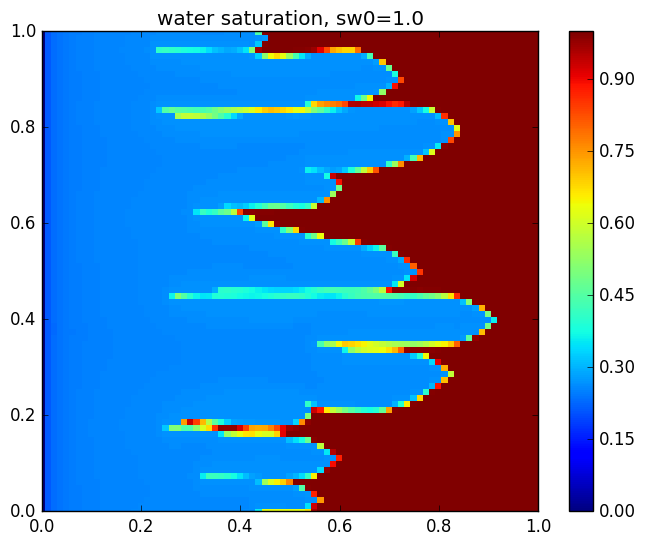

PyObject <matplotlib.text.Text object at 0x0000000038F975F8>

In [24]:
#save("case2_fullsat_2d.jld", "sw", sw2_sat)
visualizeCells(sw2_sat)
colorbar()
title("water saturation, sw0=1.0")

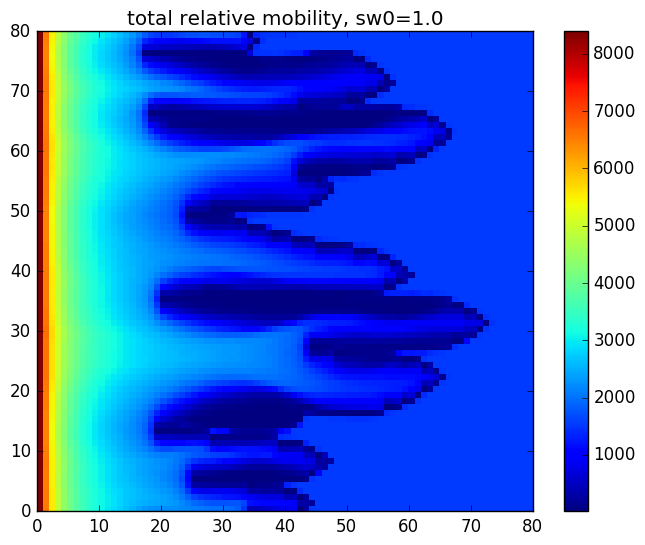

PyObject <matplotlib.text.Text object at 0x0000000039C06978>

In [25]:
# plot total relative mobility
pcolor(labda_tot_foam(sw2_sat.value[2:end-1,2:end-1]'))
colorbar()
title("total relative mobility, sw0=1.0")

## 1D model results

Time loop:100%|██████████████████████████████████████████████████| Time: 0:00:18
Time loop:100%|██████████████████████████████████████████████████| Time: 0:00:18
Time loop:100%|██████████████████████████████████████████████████| Time: 0:00:18
Time loop:100%|██████████████████████████████████████████████████| Time: 0:00:18
Time loop:100%|██████████████████████████████████████████████████| Time: 0:00:18
Time loop:100%|██████████████████████████████████████████████████| Time: 0:00:18
Time loop:100%|██████████████████████████████████████████████████| Time: 0:00:18
Time loop:100%|██████████████████████████████████████████████████| Time: 0:00:18
Time loop:100%|██████████████████████████████████████████████████| Time: 0:00:18
Time loop:100%|██████████████████████████████████████████████████| Time: 0:00:18
Time loop:100%|██████████████████████████████████████████████████| Time: 0:00:18
Time loop:100%|██████████████████████████████████████████████████| Time: 0:00:18
Time loop:100%|█████████████

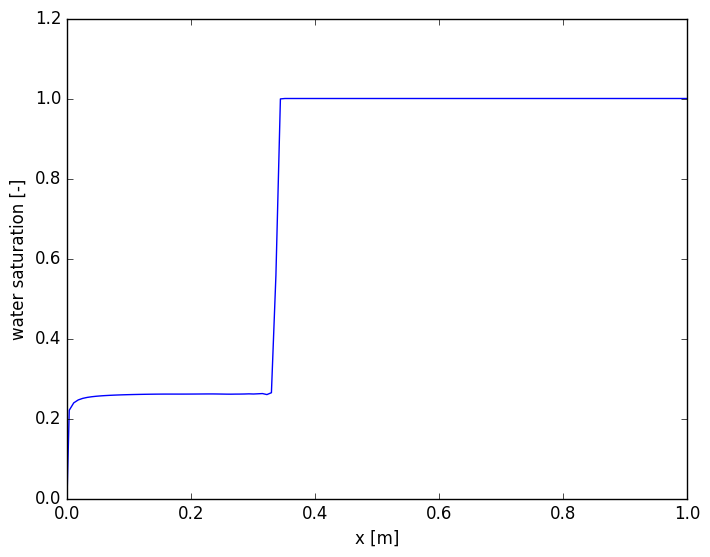

PyObject <matplotlib.text.Text object at 0x0000000072020470>

Time loop:100%|██████████████████████████████████████████████████| Time: 0:00:18
Time loop:100%|██████████████████████████████████████████████████| Time: 0:00:18
Time loop:100%|██████████████████████████████████████████████████| Time: 0:00:18
Time loop:100%|██████████████████████████████████████████████████| Time: 0:00:18
Time loop:100%|██████████████████████████████████████████████████| Time: 0:00:18
Time loop:100%|██████████████████████████████████████████████████| Time: 0:00:18
Time loop:100%|██████████████████████████████████████████████████| Time: 0:00:18


In [112]:
sw1=foam_stars(m, perm_ave=1e-12, poros_ave=0.2, sw_init=1.0, 
    fmmob=fmmob, epdry=epdry, fmdry=fmdry,
    muw=muw, mug=mug, swc=swc, sgr=sgc, krg0=krg0, ng=ng, krw0=krw0,
    nw=nw, t_final=50, dt0=50.0/100);
visualizeCells(sw1)
xlabel("x [m]")
ylabel("water saturation [-]")